# **Model Evaluation and Improvement**

We will dive deeply into evaluating models and selecting parameters.

To evaluate our supervised models, so far we have split our dataset into a training set and a test set using the **train_test_split function**, built a model on the training set by calling the fit method, and evaluated it on the test set using the **score** method, which for classification computes the fraction of correctly classified samples. Here’s an example of that process:

In [21]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a synthetic dataset
X, y = make_blobs(random_state=0)

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)

# evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


Remember, the reason we split our data into **training** and **test** sets is that we are interested in measuring how well our model generalizes to new, previously unseen data.

*We are not interested in how well our model fit the training set, but rather in how well it can make predictions for data that was not observed during training.*

In this lesson, we will expand on two aspects of this evaluation. We will first introduce **cross-validation**, a more robust way to assess generalization performance, and discuss methods to evaluate classification and regression performance that go beyond the default measures of accuracy and R2 provided by the score method.

We will also discuss **grid search**, an effective method for adjusting the parameters in supervised models for the best generalization performance.

# **1. Cross-Validation**

Cross-validation is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and a test set. **In cross-validation, the data is splitted repeatedly and multiple models are trained.**

The most commonly used version of cross-validation is **k-fold cross-validation**, where k is a user-specified number, usually 5 or 10. When performing five-fold cross-validation, the data is first partitioned into five parts of (approximately) equal size, called folds. Next, a sequence of models is trained. The first model is trained using the first fold as the test set, and the remaining folds (2–5) are used as the training set. The model is built using the data in folds 2–5, and then the accuracy is evaluated on fold 1. Then another model is built, this time using fold 2 as the test set and the data in folds 1, 3, 4, and 5 as the training set. This process is repeated using folds 3, 4, and 5 as test sets. For each of these five splits of the data into training and test sets, we compute the accuracy. In the end, we have collected five accuracy values. The process is illustrated in figure:

In [22]:
!pip install mglearn

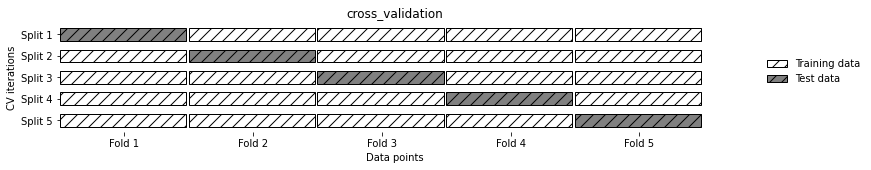

In [23]:
import mglearn
mglearn.plots.plot_cross_validation()

**Cross-Validation in scikit-learn**

Cross-validation is implemented in **scikit-learn** using the **cross_val_score** function from the **model_selection** module. The parameters of the cross_val_score function are the model we want to evaluate, the training data, and the ground-truth labels. Let’s evaluate LogisticRegression on the iris dataset:

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(max_iter=10000)
scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


By default, **cross_val_score** performs five-fold cross-validation, returning five accuracy values. We can change the number of folds used by changing the **cv** parameter:



In [25]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=10)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]


A common way to summarize the cross-validation accuracy is to compute the mean:

In [26]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.97


Using the mean cross-validation we can conclude that we expect the model to be around 97% accurate on average. Looking at all scores produced by the cross-validation, we can also conclude that there is a relatively high variance in the accuracy between folds, ranging from 100% accuracy to 93,33% accuracy. This could imply that the model is very dependent on the particular folds used for training, but it could also just be a consequence of the small size of the dataset.

**Benefits of Cross-Validation**

There are several benefits to using cross-validation instead of a single split into a training and a test set. **First**, remember that **train_test_split** performs a random split of the data. Imagine that we are **“lucky”** when randomly splitting the data, and all examples that are **hard to classify** end up in the training set. In that case, the test set will only contain **“easy”** examples, and our test set accuracy will be unrealistically high. Conversely, if we are “unlucky,” we might have randomly put all the hard-to-classify examples in the test set and consequently obtain an unrealistically low score.

However, when using cross-validation, each example will be in the training set exactly once: each example is in one of the folds, and each fold is the test set once. Therefore, the model needs to generalize well to all of the samples in the dataset for all of the cross-validation scores (and their mean) to be high.

Having multiple splits of the data also provides some information about **how sensitive our model is to the selection of the training dataset.** For the iris dataset, we saw accuracies between 93,33% and 100%. This is quite a range, and it provides us with an idea about how the model might perform in the worst case and best case scenarios when applied to new data.

Another benefit of cross-validation as compared to using a single split of the data is that we use our data more effectively. When using **train_test_split**, we usually use 75% of the data for training and 25% of the data for evaluation. When using five-fold cross-validation, in each iteration we can use four-fifths of the data (80%) to fit the model. When using 10-fold cross-validation, we can use nine-tenths of the data (90%) to fit the model. More data will usually result in more accurate models.

**The main disadvantage** of cross-validation is increased computational cost. As we are now training k models instead of a single model, cross-validation will be roughly k times slower than doing a single split of the data.

It is important to keep in mind that cross-validation is not a way to build a model that can be applied to new data. Cross-validation does not return a model. When **calling cross_val_score**, multiple models are built internally, but the purpose of cross-validation is only to evaluate how well a given algorithm will generalize when trained on a specific dataset.

**Leave-one-out cross-validation**

Another frequently used cross-validation method is **leave-one-out**. You can think of leave-one-out cross-validation as k-fold cross-validation where each fold is a single sample. For each split, you pick a single data point to be the test set. This can be very time consuming, particularly for large datasets, but sometimes provides better estimates on small datasets:

In [27]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.97


**Shuffle-split cross-validation**

Another, very flexible strategy for cross-validation is **shuffle-split cross-validation**. In **shuffle-split cross-validation**, each split samples **train_size** many points for the training set and **test_size** many (disjoint) point for the test set. This splitting is repeated **n_iter** times.

Next figure illustrates running four iterations of splitting a dataset consisting of 10 points, with a training set of 5 points and test sets of 2 points each (you can use integers for **train_size** and **test_size** to use absolute sizes for these sets, or floating-point numbers to use fractions of the whole dataset):

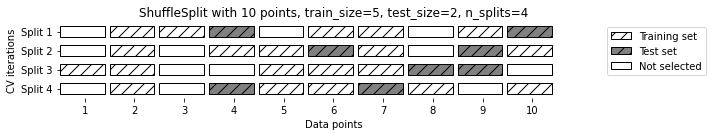

In [28]:
mglearn.plots.plot_shuffle_split()

The following code splits the dataset into 50% training set and 50% test set for 10 iterations:


In [29]:
from sklearn.model_selection import ShuffleSplit

shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.94666667 0.97333333 0.96       1.         0.97333333 0.94666667
 0.97333333 0.94666667 0.96       0.94666667]


**Shuffle-split cross-validation** allows for control over the number of iterations independently of the training and test sizes, which can sometimes be helpful. It also allows for using only part of the data in each iteration, by providing **train_size** and **test_size** settings that don’t add up to one. Sub-sampling the data in this way can be useful for experimenting with large datasets.

# **2. Grid Search**

Now that we know how to evaluate how well a model generalizes, we can take the next step and improve the model’s generalization performance by tuning its parameters. We discussed the parameter settings of many of the algorithms in scikit-learn, and it is important to understand what the parameters mean before trying to adjust them. Finding the values of the important parameters of a model (the ones that provide the best generalization performance) is a tricky task, but necessary for almost all models and datasets. Because it is such a common task, there are standard methods in scikit-learn to help you with it.

The most commonly used method is **grid search**, which basically means trying all possible combinations of the parameters of interest.

Consider the case of a kernel SVM with an RBF (radial basis function) kernel, as implemented in the SVC class. As we discussed, there are two important parameters: the kernel bandwidth, i.e. **gamma**, and the regularization parameter, i.e. **C**. Say we want to try the values 0.001, 0.01, 0.1, 1, 10, and 100 for the parameter C, and the same for gamma. Because we have six different settings for C and gamma that we want to try, we have 36 combinations of parameters in total. Looking at all possible combinations creates a table (or grid) of parameter settings for the SVM, as shown here:

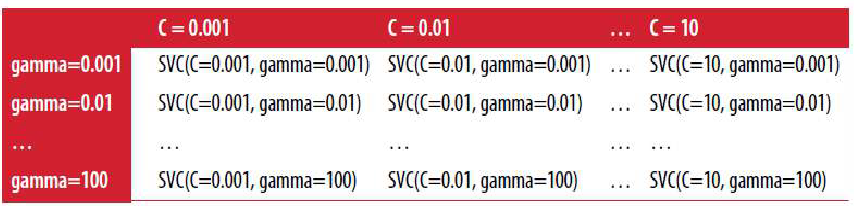



**Simple Grid Search**

We can implement a simple grid search just as for loops over the two parameters, training and evaluating a classifier for each combination:

In [11]:
# naive grid search implementation
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {} size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112 size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


**The Danger of Overfitting the Parameters and the Validation Set**

Given this result, we might be tempted to report that we found a model that performs with 97% accuracy on our dataset. However, this claim could be overly optimistic (or just wrong), for the following reason: we tried many different parameters and selected the one with best accuracy on the test set, but this accuracy won’t necessarily carry over to new data. Because we used the test data to adjust the parameters, we can no longer use it to assess how good the model is. This is the same reason we needed to split the data into training and test sets in the first place; we need an independent dataset to evaluate, one that was not used to create the model.

One way to resolve this problem is to split the data again, so we have three sets: the **training set** to build the model, the **validation set** to select the parameters of the model, and the **test set** to evaluate the performance of the selected parameters. Next figure shows what this looks like:


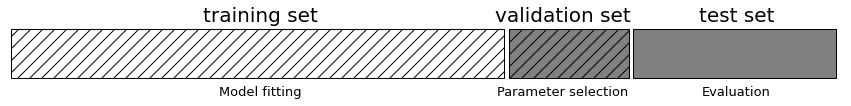

In [12]:
mglearn.plots.plot_threefold_split()

After selecting the best parameters using the validation set, we can rebuild a model using the parameter settings we found, but now training on both the training data and the validation data. This way, we can use as much data as possible to build our model. This leads to the following implementation:

In [13]:
from sklearn.svm import SVC

# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print("Size of training set: {}, size of validation set: {}, size of test set:"" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        # evaluate the SVC on the test set
        score = svm.score(X_valid, y_valid)
        
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84, size of validation set: 28, size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


The best score on the validation set is 96%: slightly lower than before, probably because we used less data to train the model (X_train is smaller now because we split our dataset twice). However, the score on the test set—the score that actually tells us how well we generalize—is even lower, at 92%. So we can only claim to classify new data 92% correctly, not 97% correctly as we thought before!

The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy “leak” information from the test set into the model. Therefore, it is important to keep a separate test set, which is only used for the final evaluation. It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation—this is even true for exploratory visualization. Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will result in an overly optimistic estimate of how accurate the model is.

**Grid Search with Cross-Validation**

While the method of splitting the data into a training, a validation, and a test set that we just saw is workable, and relatively commonly used, it is quite sensitive to how exactly the data is split. From the output of the previous code snippet we can see that GridSearchCV selects 'C': 10, 'gamma': 0.001 as the best parameters, while the output of the code in the first code selects 'C': 100, 'gamma': 0.001 as the best parameters. For a better estimate of the generalization performance, instead of using a single split into a training and a validation set, we can use **cross-validation** to evaluate the performance of each parameter combination. This method can be coded up as follows:


In [14]:
import numpy as np
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'C': 10, 'gamma': 0.1}
Test set score with best parameters: 0.97


Choosing the parameters using cross-validation, we actually found a model that achieves 97% accuracy on the test set. The important thing here is that we did not use the test set to choose the parameters. The parameters that were found are scored in the **best_params_** attribute, and the best cross-validation accuracy (the mean accuracy over the different splits for this parameter setting) is stored in **best_score_**.

 
**Task.** Use **kNeighboursClassifier** (n_neighbors=5) for iris dataset. Evaluate the error by using cross-validation (cv=10). Search for an optimal value of k (k=1,..., 30) using grid search. Plot the value of k for KNN (x-axis) versus the cross-validated accuracy (y-axis). The following link can be useful. 

https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/